In [1]:
from pathlib import Path
import sys

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
#from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob
import torch.nn.functional as F
import warnings
from sklearn.metrics import mean_squared_error
#import mae function
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

In [4]:
# dataread and features
from data.preprocess import read_txn_data , preprocess_txn_data, compute_lob_features, \
    create_lob_dataset, merge_txn_and_lob

# desesonalisation
from models.deseasonalization import deses

# Parameters

In [5]:
def set_neurips_style():
    plt.rcParams.update({
        "font.family":       "sans-serif",
        "font.size":         12,
        "axes.spines.top":   False,
        "axes.spines.right": False,
        "axes.grid":         True,
        "grid.linestyle":    ":",
        "grid.alpha":        0.5,
        "figure.dpi":        120,
        "legend.frameon":    False,
    })

set_neurips_style()

In [6]:
config = {
    "data_split": {
        "train_size": 0.7,
        "validation_size": 0.1,
        "test_size": 0.2
    },
    "model_params": {
        "learning_rate": 0.1,
        "batch_size": 4096,
        "epochs": 15
        ,
    }
}




# Check GPU 

In [7]:
import torch

if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Reserved : {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Max Rsvd : {torch.cuda.max_memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available.")


Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Allocated: 0.00 MB
Reserved : 0.00 MB
Max Alloc: 0.00 MB
Max Rsvd : 0.00 MB


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 Min 

#### 1.1 Load Data

In [9]:
freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{c|c|c|c|c}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(3,3)-GARCH(1,1) } & 14.587 & 7.688 & \mathbf{1 . 7 1 9} & 97.618 \\
\text { ARMAX(3,3)-GARCH(1,1) } & 14.292 & 7.487 & 1.719 & 93.943 \\
\text { GBM } & 11.740 & \mathbf{3 . 5 1 5} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{1 1 . 3 7 8} & 4.299 & 1.720 & \mathbf{1 0 . 2 9 5} \\
\hline
\end{array}

trx Data loaded successfully.
preprocessed lob Data loaded successfully.
ep01  train 5.3862  val 4.6098
ep02  train 4.6861  val 4.4907
ep03  train 4.5349  val 4.3157
ep04  train 4.2809  val 3.9334
ep05  train 1998.9148  val 641.3737
ep06  train 515.1369  val 186.5609
ep07  train 114.5939  val 29.8184
ep08  train 17.7554  val 6.8566
ep09  train 5.8355  val 4.9178
ep10  train 4.9881  val 4.8447
ep11  train 4.9634  val 4.8451
ep12  train 4.9634  val 4.8448
ep13  train 4.9631  val 4.8446
ep14  train 4.9633  val 4.8446
ep15  train 4.9630  val 4.8445


C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:191: RuntimeWarning: overflow encountered in exp
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv
C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:191: RuntimeWarning: overflow encountered in multiply
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv
C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:191: RuntimeWarning: invalid value encountered in multiply
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv


Metric     |      Value
-----------------------
RMSE         |      12.11
MAE           |       4.56
R²             |    -0.0561
MAPE (%)  |     190.08
Coverage  |      100.0 %
IW             |        nan
NNLL         |  6027.7550


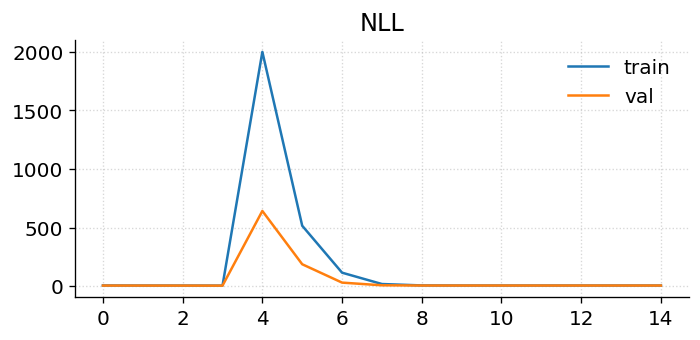

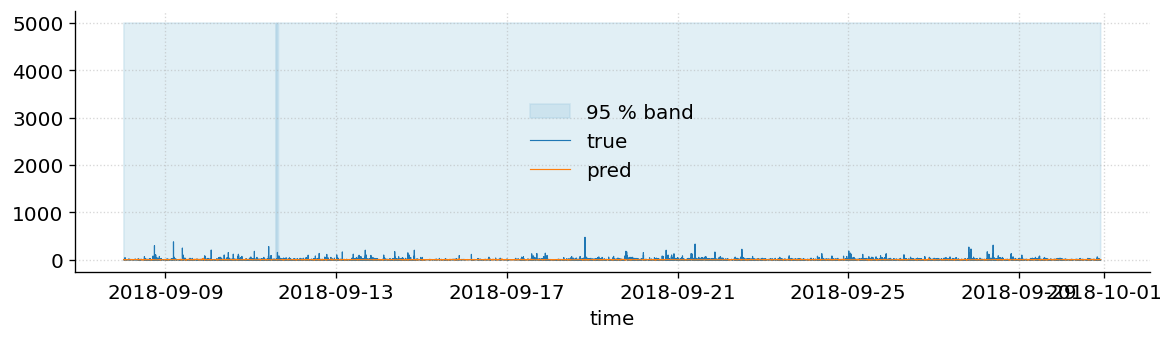

In [10]:
freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots

# 5 Min

#### 1.1 Load Data

In [11]:
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{|c|c|c|c|c|}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(5,4)-GARCH(1,1) } & 38.300 & 17.606 & \mathbf{3 . 7 3 2} & 34.797 \\
\text { ARMAX(5,4)-GARCH(1,1) } & 40.273 & 18.887 & 3.766 & 38.250 \\
\text { GBM } & 39.196 & \mathbf{1 4 . 7 1 4} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{3 8 . 2 2 3} & 17.287 & 3.765 & \mathbf{2 9 . 1 4 8} \\
\hline
\end{array}

ep01  train 20.4137  val 16.6883
ep02  train 20.6080  val 7.5702
ep03  train 6.4110  val 5.1633
ep04  train 5.3793  val 5.2446
ep05  train 5.4574  val 5.3148
ep06  train 5.5496  val 5.3882
ep07  train 5.6251  val 5.4191
ep08  train 5.6367  val 5.4050
ep09  train 5.6023  val 5.3774
ep10  train 5.5645  val 5.3559
ep11  train 5.5388  val 5.3424
ep12  train 5.5239  val 5.3337
ep13  train 5.5128  val 5.3273
ep14  train 5.5067  val 5.3217
ep15  train 5.5010  val 5.3162


C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:191: RuntimeWarning: overflow encountered in exp
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv


Metric     |      Value
-----------------------
RMSE         |      38.46
MAE           |      16.54
R²             |    -0.1856
MAPE (%)  |     156.18
Coverage  |      100.0 %
IW             |        inf
NNLL         |     5.2351


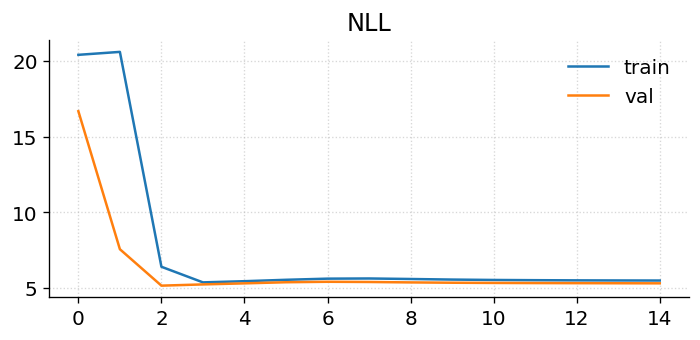

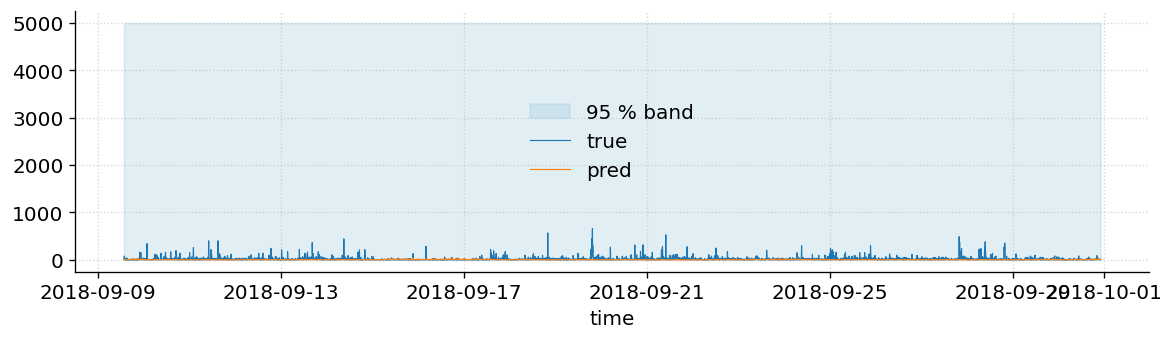

In [12]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots

# 10 Min

#### 1.1 Load Data

In [13]:
freq='10min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{|c|c|c|c|c|}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(3,2)-GARCH(1,1) } & 66.486 & 31.942 & \mathbf{4 . 4 5 2} & 51.228 \\
\text { ARMAX(3,2)-GARCH(1,1) } & 68.067 & 32.795 & 4.457 & 52.780 \\
\text { GBM } & 67.128 & \mathbf{2 7 . 7 1 9} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{6 6 . 2 3 4} & 31.460 & 4.507 & \mathbf{4 9 . 9 7 2} \\
\hline
\end{array}

In [14]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots

ep01  train 145795.5596  val 1841.9434
ep02  train 50011.7569  val 134243.3551
ep03  train 129487.2845  val 44796.9575
ep04  train 28613.8801  val 2629.1078
ep05  train 1205.7750  val 199.4964
ep06  train 613.4192  val 1054.3308
ep07  train 1273.2879  val 1027.7078
ep08  train 1010.1141  val 543.0615
ep09  train 445.7535  val 133.0348
ep10  train 81.0199  val 22.0185
ep11  train 61.8039  val 160.2714
ep12  train 260.8485  val 352.6834
ep13  train 447.0968  val 425.6278
ep14  train 467.4393  val 340.4475
ep15  train 330.6680  val 181.7962
Metric     |      Value
-----------------------


C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:190: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(mu_log) * mv
C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:191: RuntimeWarning: overflow encountered in exp
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv
C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:192: RuntimeWarning: invalid value encountered in subtract
  low, up = y_pred - 0.5*sigma, y_pred + 0.5*sigma


ValueError: Input contains infinity or a value too large for dtype('float64').